<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment7/assignment7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all the required python libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Input, concatenate, GlobalAveragePooling2D, Reshape
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model

In [0]:
from keras.datasets import cifar10

# downloads the CIFAR10 dataset and splits it into test and train.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# calculate the dimensions and number of classes
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

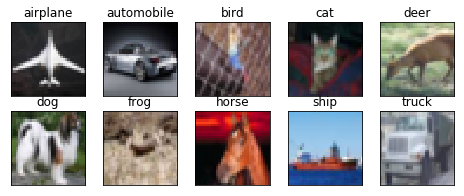

In [20]:
# gallery to display 1 image from each of the classes

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# function to plot loss and accuracy of the network

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# function to calculate accuacy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#pixel normalization of test and train data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255


# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [61]:
# Define the model
# Using functional API as we need to use group convolution

input_img = Input(shape=(32, 32, 3))

x1 = Conv2D(32, (3, 3), padding='same')(input_img) # RF: 3x3
x1_bn = BatchNormalization()(x1)
x1_act = Activation('relu')(x1_bn)

x2 = DepthwiseConv2D(kernel_size=5, strides=(1, 1), padding='same')(x1_act) # RF: 7x7
x3 = Conv2D(32, (1, 1), padding='same')(x2)
x3_bn = BatchNormalization()(x3)
x3_act = Activation('relu')(x3_bn)

x4 = Conv2D(32, (5, 5), padding='same')(x3_act) # RF: 11x11
x4_bn = BatchNormalization()(x4)
x4_act = Activation('relu')(x4_bn)

x5 = Conv2D(32, (5, 5), padding='same')(x4_act) # RF: 15x15
x5_bn = BatchNormalization()(x5)
x5_act = Activation('relu')(x5_bn)

x6 = DepthwiseConv2D(kernel_size=5, strides=(1, 1), padding='same')(concatenate([x3_act,x5_act])) # RF: 19x19
x7 = Conv2D(32, (1, 1), padding='same')(x6)
x7_bn = BatchNormalization()(x7)
x7_act = Activation('relu')(x7_bn)

x8 = MaxPooling2D((3,3), strides=1, padding='same')(concatenate([x3_act,x7_act])) # RF: 21x21
x8_bn = BatchNormalization()(x8)
x8_act = Activation('relu')(x8_bn)

x9 = DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same')(x8_act) # RF: 23x23
x10 = Conv2D(32, (1, 1), padding='same')(x9) # RF: 7x7
x10_bn = BatchNormalization()(x10)
x10_act = Activation('relu')(x10_bn)

x11 = Conv2D(32, (5, 5), padding='same')(concatenate([x3_act,x10_act])) # RF: 27x27
x11_bn = BatchNormalization()(x11)
x11_act = Activation('relu')(x11_bn)


x12 = DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same')(concatenate([x5_act,x7_act,x10_act,x11_act])) # RF: 29x29
x13 = Conv2D(32, (1, 1), padding='same')(x12) # RF: 7x7
x13_bn = BatchNormalization()(x13)
x13_act = Activation('relu')(x13_bn)


x14 = DepthwiseConv2D(kernel_size=5, strides=(1, 1), padding='same')(concatenate([x3_act, x5_act,x7_act,x10_act,x11_act,x13_act])) # RF: 33x33
x15 = Conv2D(32, (1, 1), padding='same')(x14) # RF: 7x7
x15_bn = BatchNormalization()(x15)
x15_act = Activation('relu')(x15_bn)


x16 = MaxPooling2D((3,3), strides=1, padding='same')(concatenate([x3_act,x7_act,x10_act,x13_act,x15_act]))  # RF: 35x35
x16_bn = BatchNormalization()(x16)
x16_act = Activation('relu')(x16_bn)


x17 = Conv2D(32, (5, 5), padding='same')(concatenate([x11_act,x16_act])) # RF: 39x39
x17_bn = BatchNormalization()(x11)
x17_act = Activation('relu')(x11_bn)


x18 = DepthwiseConv2D(kernel_size=5, strides=(1, 1), padding='same')(concatenate([x4_act, x7_act,x13_act,x17_act])) # RF: 43x43
x19 = Conv2D(32, (1, 1), padding='same')(x18) # RF: 7x7
x19_bn = BatchNormalization()(x19)
x19_act = Activation('relu')(x19_bn)


x20 = Conv2D(32, (3, 3), padding='same')(concatenate([x4_act, x5_act,x10_act,x17_act,x19_act])) # RF: 45x45
x20_bn = BatchNormalization()(x1)
x20_act = Activation('relu')(x1_bn)

x21 = DepthwiseConv2D(kernel_size=5, strides=(1, 1), padding='same')(concatenate([x3_act, x5_act, x7_act, x10_act, x13_act, x19_act, x20_act])) # RF: 49x49
x22 = Conv2D(32, (1, 1), padding='same')(x21) # RF: 7x7
x22_bn = BatchNormalization()(x22)
x22_act = Activation('relu')(x22_bn)

x23 = concatenate([x7_act, x13_act, x19_act, x22_act])
x24 = Conv2D(num_classes, (1, 1), padding='same')(x23)
x25 = GlobalAveragePooling2D()(x24)

out = Activation('softmax')(x25)

model = Model(inputs=[input_img], outputs=[out])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_381 (Conv2D)             (None, 32, 32, 32)   896         input_39[0][0]                   
__________________________________________________________________________________________________
batch_normalization_411 (BatchN (None, 32, 32, 32)   128         conv2d_381[0][0]                 
__________________________________________________________________________________________________
activation_418 (Activation)     (None, 32, 32, 32)   0           batch_normalization_411[0][0]    
__________________________________________________________________________________________________
depthwise_

Epoch 1/100
  1/390 [..............................] - ETA: 1:01 - loss: 0.3054 - acc: 0.9062

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


390/390 [==============================] - 47s 120ms/step - loss: 0.4180 - acc: 0.8536 - val_loss: 1.5157 - val_acc: 0.6186
Epoch 2/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3960 - acc: 0.8625 - val_loss: 1.6952 - val_acc: 0.5214
Epoch 3/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3808 - acc: 0.8674 - val_loss: 0.9055 - val_acc: 0.7289
Epoch 4/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3602 - acc: 0.8759 - val_loss: 1.0719 - val_acc: 0.6716
Epoch 5/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3439 - acc: 0.8803 - val_loss: 1.2526 - val_acc: 0.6760
Epoch 6/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3297 - acc: 0.8849 - val_loss: 1.2048 - val_acc: 0.7047
Epoch 7/100
390/390 [==============================] - 47s 120ms/step - loss: 0.3126 - acc: 0.8920 - val_loss: 0.9956 - val_acc: 0.7183
Epoch 8/100
390/390 [==============================] - 47s 1

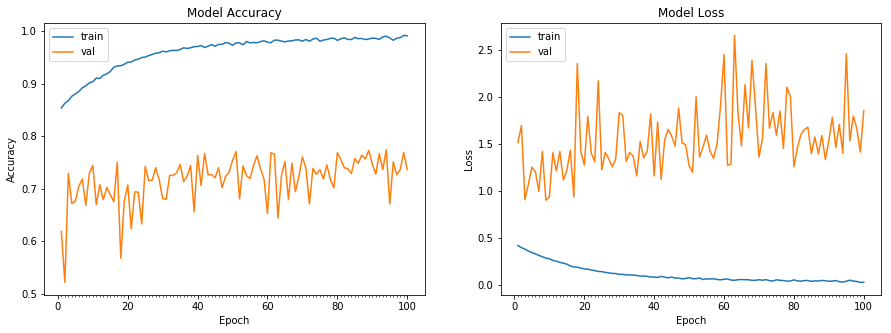

Accuracy on test data is: 73.62


In [63]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))